In [4]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [5]:
# Function for converting series data to a supervised data of format, t-1, t, t+1
## Basically feeding in the (t-1)th data to predict the t data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [6]:
#/Users/sakshikarnawat/Desktop/valet-tool
# load dataset
dataset = read_csv('/Users/sakshikarnawat/Desktop/CapstoneResults/A_val_train.csv')
# dataset= dataset.drop(columns=["timestamp","ping_timestamp","ping_success"])
values = dataset.values
print(dataset.head(5))
## Load Validation
validation = read_csv('/Users/sakshikarnawat/Desktop/CapstoneResults/A_test.csv')
# validation= validation.drop(columns=["timestamp","ping_timestamp","ping_success"])
values_validation = validation.values


   Unnamed: 0  Hours  Minutes    Seconds  Cost  Friday  Monday  Saturday  \
0      185785      9       36  14.184037  25.7       1       0         0   
1      118246     21       41  36.496268  24.8       0       1         0   
2      224521      9       54  28.717120  25.6       0       0         0   
3      151658     15       42  45.761458  24.7       0       0         0   
4      243069     14       23  52.160267  25.3       0       1         0   

   Sunday  Thursday  Tuesday  Wednesday  A  B  C  A'  B'  C'  
0       0         0        0          0  0  0  0   0   1   0  
1       0         0        0          0  0  0  0   0   0   1  
2       1         0        0          0  0  0  0   0   0   1  
3       0         0        0          1  0  1  0   0   1   0  
4       0         0        0          0  0  0  1   0   0   1  


In [7]:
## Calling the function to do the preprocessing the data and removing unwanted columns


# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed_validation = series_to_supervised(values_validation, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,10,11]], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[[6,10,11]], axis=1, inplace=True)
print(reframed.head(1))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   185785.0        9.0       36.0  14.184037       25.7        1.0   

   var8(t-1)  var9(t-1)  var10(t-1)  var13(t-1)  ...  var9(t)  var10(t)  \
1        0.0        0.0         0.0         0.0  ...      0.0       0.0   

   var11(t)  var12(t)  var13(t)  var14(t)  var15(t)  var16(t)  var17(t)  \
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   var18(t)  
1       1.0  

[1 rows x 33 columns]


In [8]:
## Splitting the data into training and validation sets


train = reframed.values
test = reframed_validation.values
# split into input and outputs
train_X, train_y = train[:, :-3], train[:,-3:]
test_X, test_y = test[:, :-3], test[:,-3:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(166708, 1, 30) (166708, 3) (52096, 1, 30) (52096, 3)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1000)              4124000   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3003      
Total params: 4,127,003
Trainable params: 4,127,003
Non-trainable params: 0
_________________________________________________________________
None
Train on 166708 samples, validate on 52096 samples
Epoch 1/20
166708/166708 [==============================] - 250s 2ms/step - loss: 0.2292 - val_loss: 0.2234
Epoch 2/20
166708/166708 [==============================] - 253s 2ms/step - loss: 0.2259 - val_loss: 0.2231
Epoch 3/20
166708/166708 [==============================] - 281s 2ms/step - loss: 0.2257 - val_loss: 0.2229
Epoch 4/20
166708/166708 [==============================] - 270s 2ms/step - loss: 0.2257 - val_loss: 0.2230
Epoch 5/20
166708/

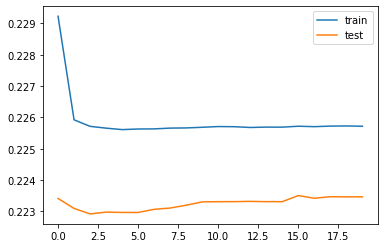

In [9]:
# design LSTM network  has 1000 hidden layers , used adam optimizer and mse loss function
model = Sequential()
model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))

print(model.summary())

model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [11]:
### Doing the same process for testing dataset

#test_dataset = read_csv('normalized_tva_server_2_tactic_1_validation.csv')
test_dataset = read_csv('/Users/sakshikarnawat/Desktop/CapstoneResults/A_val_test.csv')
# test_dataset= test_dataset.drop(columns=["timestamp","ping_timestamp","ping_success"])
print(test_dataset.head())
test_values = test_dataset.values
reframed_test = series_to_supervised(test_values, 1, 1)
reframed_test.drop(reframed_test.columns[[6,10,11]], axis=1, inplace=True)
testset = reframed_test.values
testset_X, testset_y = testset[:, :-3], testset[:,-3:]
testdataReshaped = testset_X.reshape((testset_X.shape[0], 1, testset_X.shape[1]))
print(testset_X.shape, testset_X.shape)

   Unnamed: 0  Hours  Minutes    Seconds  Cost  Friday  Monday  Saturday  \
0      239535      9       47  10.611630  26.1       0       1         0   
1       17510     16       41  14.119838   8.6       0       0         0   
2      137690     22       11  19.320848  24.9       0       0         0   
3      142526      4        6  54.611408  26.9       0       0         0   
4        6133      0       55   5.142670  26.7       0       0         0   

   Sunday  Thursday  Tuesday  Wednesday  A  B  C  A'  B'  C'  
0       0         0        0          0  0  0  0   1   0   0  
1       0         0        0          1  1  0  0   1   0   0  
2       0         0        1          0  0  0  0   1   0   0  
3       0         0        0          1  0  0  0   0   1   0  
4       0         0        0          1  0  0  0   0   0   1  
(41677, 30) (41677, 30)


In [12]:
## Feeding the test dataset for predictions
import pandas as pd

yhat = model.predict(testdataReshaped)

print(yhat)
dataset = pd.DataFrame({ 'predicted_Cost': yhat[:, 1]})
# dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] >0.5] = 1
# dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] <0.5] = 0

[[0.3307816  0.38213822 0.29446188]
 [0.3307816  0.38213822 0.29446188]
 [0.3307816  0.38213822 0.29446188]
 ...
 [0.3307816  0.38213822 0.29446188]
 [0.3307816  0.38213822 0.29446188]
 [0.3307816  0.38213822 0.29446188]]


In [13]:
frames = [test_dataset, dataset]
result = pd.concat(frames,axis =1)

In [14]:
import numpy as np
result.head(10)
result.to_csv('/Users/sakshikarnawat/Desktop/CapstoneResults/predictions_LSTM.csv', sep=',', index=0)



In [15]:
print(testset_y)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [16]:
## Finding the root mean squared error of the model
import numpy as np

rmse = np.sqrt(mean_squared_error(yhat, testset_y))
print('Test RMSE: ' , rmse)

Test RMSE:  0.4727953956195655


In [17]:
mse = mean_squared_error(yhat, testset_y)
print('Test MSE: ',  mse)

Test MSE:  0.22353548611906146


In [18]:
mae = mean_absolute_error(yhat, testset_y)
print('Test MAE: ',  mae)

Test MAE:  0.44527810566390863
